In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pre_processing.textProcessing import TextPreProcessor
import nltk
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from matplotlib import pyplot as plt
# nltk.download('omw-1.4')

ModuleNotFoundError: No module named 'pre_processing'

# Initial EDA

### Read Data

In [7]:
train = pd.read_csv('/Users/caseyhsiung/Documents/Berkeley/W207/jigsaw-toxic-comment-classification-challenge/train.csv')

df = pd.DataFrame(train)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Identify number of null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

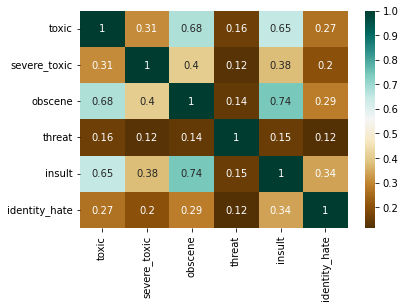

In [11]:
# Correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap='BrBG')

pass

In [14]:
# Check for text that have no classifications
df['empty_category'] = df.iloc[:, 2:6].sum(axis=1)
df.loc[df['empty_category'] > 0, ['empty_category']] = 1

df.loc[df['empty_category'] == 1].count()

id                15842
comment_text      15842
toxic             15842
severe_toxic      15842
obscene           15842
threat            15842
insult            15842
identity_hate     15842
empty_category    15842
dtype: int64

### Create Sample

In [5]:
# Sample 1000 to experiment with
train_samp = train.sample(1000, random_state=923).reset_index(drop=True)

In [6]:
train_samp
doc = train_samp.comment_text

### Process a single document 

In [7]:
def tokenize(text):
    """
    Define a function that take in a text and process the doc
    """
    return TextPreProcessor(text=text, lemma_flag=True, stem_flag=False).process()

target_doc = doc[0]
print('---Original Doc---')
print(target_doc)

print('\n\n---Processed Doc---')
print(tokenize(target_doc))

---Original Doc---
"

 You're a liar and on ArbCom, what a shock 

I know within the bubble of Wikiality (""I don't really have a problem with it."" - porn magnate and Randroid Jimbo Wales) no one has a problem with a fantastic liar to you being on ArbCom, but I guess some of that...*real*-ity and outside world crept in and now you have been thrown overboard.  Wikipedia's descent continues.

I expect this comment will be deleted by some cultish cabal'er.  I'm counting the minutes!  "


---Processed Doc---
['liar', 'arbcom', 'shock', 'know', 'within', 'bubble', 'wikiality', 'really', 'problem', 'porn', 'magnate', 'randroid', 'jimbo', 'wale', 'one', 'problem', 'fantastic', 'liar', 'arbcom', 'guess', 'thatreality', 'outside', 'world', 'creep', 'throw', 'overboard', 'wikipedias', 'descent', 'continue', 'expect', 'comment', 'delete', 'cultish', 'cabaler', 'count', 'minute']


# Process text for feature-based modeling
1. Process each document
2. Turn the documents into a Document-term matrix

In [8]:
# Fit the Count vectorizer
vec_count = CountVectorizer(ngram_range=(1,1),tokenizer=tokenize,min_df=15, max_df=0.9)
vec_count_f = vec_count.fit(doc)

/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [9]:
dtm = vec_count_f.transform(doc)
dtm_df = pd.DataFrame(dtm.toarray())
dtm_df.columns = vec_count_f.get_feature_names_out()

/Users/xiaoma/envs/ds207/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
dtm_df.head()

,1,2,2005,2006,2008,5,able,accept,account,accuse,...,without,word,work,world,would,write,wrong,year,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Process for Recurrent Neural Network
1. Process each doc
2. Turn each doc into a numeric representation
3. Do Padding

In [11]:
processed_docs = [tokenize(x) for x in doc]

# Create the tokenizer for NN processing
t = Tokenizer()
# Fit the tokenizer on the documents
t.fit_on_texts(processed_docs)
# Transform docs into numeric rep
encoded_docs = t.texts_to_sequences(processed_docs)

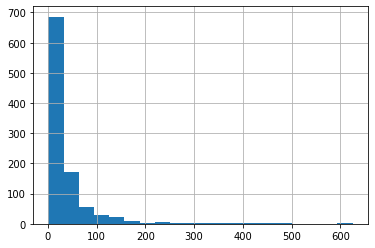

In [15]:
# Find the optimal lengths for padding
pd.Series(encoded_docs).apply(lambda x: len(x)).hist(bins = 20);

In [16]:
max_len = 150 # Most of the documents are less than length 150
padded_doc = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

In [19]:
print("---Original text---")
print(doc[0])

print('\n---Processed text---')
print(processed_docs[0])

print('\n---Encoded text---')
print(encoded_docs[0])

print('\n---Padded text---')
print(padded_doc[0])

---Original text---
"

 You're a liar and on ArbCom, what a shock 

I know within the bubble of Wikiality (""I don't really have a problem with it."" - porn magnate and Randroid Jimbo Wales) no one has a problem with a fantastic liar to you being on ArbCom, but I guess some of that...*real*-ity and outside world crept in and now you have been thrown overboard.  Wikipedia's descent continues.

I expect this comment will be deleted by some cultish cabal'er.  I'm counting the minutes!  "

---Processed text---
['liar', 'arbcom', 'shock', 'know', 'within', 'bubble', 'wikiality', 'really', 'problem', 'porn', 'magnate', 'randroid', 'jimbo', 'wale', 'one', 'problem', 'fantastic', 'liar', 'arbcom', 'guess', 'thatreality', 'outside', 'world', 'creep', 'throw', 'overboard', 'wikipedias', 'descent', 'continue', 'expect', 'comment', 'delete', 'cultish', 'cabaler', 'count', 'minute']

---Encoded text---
[1030, 1418, 2324, 18, 609, 3535, 3536, 56, 123, 2325, 3537, 3538, 1419, 1420, 13, 123, 3539, 103

In [22]:
pd.DataFrame(padded_doc)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1030,1418,2324,18,609,3535,3536,56,123,2325,...,0,0,0,0,0,0,0,0,0,0
1,130,268,107,237,137,193,2327,1032,5,514,...,0,0,0,0,0,0,0,0,0,0
2,3547,137,38,611,364,3548,238,2329,21,515,...,0,0,0,0,0,0,0,0,0,0
3,1733,3550,249,3551,3552,1035,3553,3554,753,0,...,0,0,0,0,0,0,0,0,0,0
4,30,2331,1190,3555,3556,30,2331,1190,3557,50,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1450,21,333,170,10,275,1425,1,8244,8245,...,0,0,0,0,0,0,0,0,0,0
996,12,16,475,110,82,174,40,105,847,110,...,0,0,0,0,0,0,0,0,0,0
997,18,467,8249,643,91,27,3332,803,83,1086,...,0,0,0,0,0,0,0,0,0,0
998,1507,8254,17,8255,73,63,22,31,567,801,...,0,0,0,0,0,0,0,0,0,0
